## **<span style="color:#0918D5 ;">This notebook contains 9 different models with tuned-parameters using Optuna. Also submission done using random 5 models (using VotingClassifier).</span>**

## **<span style="color:#0918D5 ;">Each model is tuned for 100 iteration and using 5-Stratified-Folds.</span>**

## **<span style="color:#0918D5 ;">I hope this helps some of us. If yes, don't forget to upvote ;-)</span>**

## **<span style="color:#0918D5 ;">Introduction</span>**
Welcome to the year 2912, where your data science skills are needed to solve a cosmic mystery. We've received a transmission from four lightyears away and things aren't looking good.

The Spaceship Titanic was an interstellar passenger liner launched a month ago. With almost 13,000 passengers on board, the vessel set out on its maiden voyage transporting emigrants from our solar system to three newly habitable exoplanets orbiting nearby stars.

While rounding Alpha Centauri en route to its first destination—the torrid 55 Cancri E—the unwary Spaceship Titanic collided with a spacetime anomaly hidden within a dust cloud. Sadly, it met a similar fate as its namesake from 1000 years before. Though the ship stayed intact, almost half of the passengers were transported to an alternate dimension!

## **<span style="color:#0918D5 ;">Data Dictionary</span>**
- **<span style="color:#0918D5 ;">PassengerId</span>** - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
- **<span style="color:#0918D5 ;">HomePlanet</span>** - The planet the passenger departed from, typically their planet of permanent residence.
- **<span style="color:#0918D5 ;">CryoSleep</span>** - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
- **<span style="color:#0918D5 ;">Cabin</span>** - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
- **<span style="color:#0918D5 ;">Destination</span>** - The planet the passenger will be debarking to.
- **<span style="color:#0918D5 ;">Age</span>** - The age of the passenger.
- **<span style="color:#0918D5 ;">VIP</span>** - Whether the passenger has paid for special VIP service during the voyage.
- **<span style="color:#0918D5 ;">RoomService, FoodCourt, ShoppingMall, Spa, VRDeck</span>** - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
- **<span style="color:#0918D5 ;">Name</span>** - The first and last names of the passenger.
- **<span style="color:#0918D5 ;">Transported</span>** - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

# **<span style="color:#0918D5 ;">Importing Required Libraries</span>**

In [ ]:
!pip install proplot

In [ ]:
!pip install optuna

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer

from sklearn.model_selection import train_test_split, StratifiedKFold

import statsmodels.api as sm

import optuna
from sklearn import preprocessing
from sklearn import metrics

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              ExtraTreesClassifier, BaggingClassifier,
                              GradientBoostingClassifier, GradientBoostingClassifier)
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings('ignore')

# **<span style="color:#0918D5 ;">Loading Data</span>**

In [ ]:
df = pd.read_csv('../input/spaceship-titanic/train.csv')
df_test = pd.read_csv('../input/spaceship-titanic/test.csv')
sample_submission = pd.read_csv('../input/spaceship-titanic/sample_submission.csv')

df.head()

# **<span style="color:#0918D5 ;">Missing Values Analysis</span>**

In [ ]:
display(((df.isnull().sum() / df.shape[0])*100).to_frame().rename({0: 'Missing Values % (Train)'}, axis = 1).style.background_gradient('gist_heat_r'))
display(((df_test.isnull().sum() / df_test.shape[0])*100).to_frame().rename({0: 'Missing Values % (Test)'}, axis = 1).style.background_gradient('gist_heat_r'))

In [ ]:
missing_val_df = ((df.isnull().sum() / df.shape[0])*100).to_frame().reset_index().rename({'index': 'columns', 0: 'Missing Values percentage'}, axis = 1)

plt.figure(figsize = (16,8))
sns.barplot(data = missing_val_df, x = 'Missing Values percentage', y = 'columns',palette='dark')
plt.title('Missing Values percentage Training Data', fontsize = 20, fontweight = 'bold', color = '#bd0b0b')
plt.xlabel(" ")
plt.ylabel(" ")
plt.xticks(fontsize = 12, fontweight = 'bold', color = 'maroon')
plt.yticks(fontsize = 12, fontweight = 'bold', color = 'maroon');


missing_val_df_test = ((df_test.isnull().sum() / df_test.shape[0])*100).to_frame().reset_index().rename({'index': 'columns', 0: 'Missing Values percentage'}, axis = 1)

plt.figure(figsize = (16,8))
sns.barplot(data = missing_val_df_test, x = 'Missing Values percentage', y = 'columns',palette='dark')
plt.title('Missing Values percentage Testing Data', fontsize = 20, fontweight = 'bold', color = '#bd0b0b')
plt.xlabel(" ")
plt.ylabel(" ")
plt.xticks(fontsize = 12, fontweight = 'bold', color = 'maroon')
plt.yticks(fontsize = 12, fontweight = 'bold', color = 'maroon');

### **<span style="color:#0918D5 ;">Observations:</span>**
- Missing values doesnt seem to follow a pattern in training and testing datasets.
- In training data: **CryoSleep** and **Age** has highest and second lowest missing values percentages. **PassengerId** and **Transported** doesn't have any missing values (lowest %age).
- In testing data: **FoodCourt** and **VRDeck** has highest and second lowest missing values percentages. **PassengerId** doesn't have any missing values (lowest %age).

## **<span style="color:#0918D5 ;">Missing values imputation</span>**
- Categorical : Group by + Mode
- Float: Iterative Imputer

## **<span style="color:#0918D5 ;">Combining train and test dataset</span>**
- Plan here is to get mode from maximum data available for categorical variables and 
- Get best prediction of missing values using MICE methodology (using iterative imputer). To make sure data leakage doesn't happen:
    - Removed target variable when using iterative imputer
    - Make copy of the dataset and perform missing imputation in copied dataset and take only required columns from the copied set. 

In [ ]:
df['isTrain'] = True
df_test['isTrain'] = False
tt = pd.concat([df, df_test]).reset_index(drop = True).copy()
tt.head()

## **<span style="color:#0918D5 ;">Imputing Missing values in Categorical columns</span>**

In [ ]:
"""Mode for Destination and VIP """
tt['Destination'] = tt['Destination'].fillna(tt['Destination'].mode()[0])
tt['VIP'] = tt['VIP'].fillna(tt['VIP'].mode()[0])

"""For CyroSleep, Cabin, HomePlanet: Mode after Grouping by Destination and VIP"""
tt['CryoSleep'] = tt.groupby(['Destination', 'VIP'])['CryoSleep'].transform(lambda x: x.fillna(x.mode()[0]))
tt['Cabin'] = tt.groupby(['CryoSleep', 'VIP'])['Cabin'].transform(lambda x: x.fillna(x.mode()[0]))
tt['HomePlanet'] = tt.groupby(['CryoSleep', 'VIP'])['HomePlanet'].transform(lambda x: x.fillna(x.mode()[0]))

"""For missing Names: Used keyword- Missing"""
tt['Name'] = tt['Name'].fillna("MISSING")

## **<span style="color:#0918D5 ;">Imputing Missing values in Numerical columns</span>**

In [ ]:
"""Created List of columns according to the data-types"""
useful_cols = [col for col in tt.columns if col not in ['PassengerId','isTrain','Transported']]
cat_cols = [col for col in useful_cols if tt[col].dtype == 'object']
bool_cols = ['VIP', 'CryoSleep']
col_num = [col for col in useful_cols if col not in (cat_cols+bool_cols)]

"""Preprocessing for Using Iterative Imputer"""
comb_df = tt.copy()                # Making copy of combined data
le = preprocessing.LabelEncoder()  # Label Encoding Categrorical columns
for i in cat_cols:
    comb_df[i] = le.fit_transform(comb_df[i])

"""Imputing missing values of Float-type data using Iterative Imputer"""
it_imputer = IterativeImputer(max_iter=1000)
iterimp = it_imputer.fit_transform(comb_df[useful_cols])
imp_df = pd.DataFrame(iterimp, columns=comb_df[useful_cols].columns)

for col in comb_df[col_num].columns:
    tt[col] = imp_df[col]

tt.head()

## **<span style="color:#0918D5 ;">Taking out Training and Testing set from combined Dataset.</span>**

In [ ]:
for col in comb_df[col_num].columns:
    comb_df[col] = imp_df[col]
    
    
"""Taking out Training and Testing set from combined Dataset."""
train = comb_df[comb_df.isTrain == True].drop('isTrain', axis= 1)
test = comb_df[comb_df.isTrain != True].drop(['isTrain','Transported'], axis =1)

"""Checking missing values"""
print(f"Missing values in Training Set: {train.isnull().sum().sum()} \
\nMissing values in Test Set: {test.isnull().sum().sum()}")

## **<span style="color:#0918D5 ;">Describing the Imputed Dataset (Training)</span>**


In [ ]:
train.describe().style.background_gradient(cmap="Pastel1")

# **<span style="color:#0918D5 ;">Exploratory Data Analysis (EDA)</span>**
### Refer to: https://www.kaggle.com/code/snikhil17/titanic-eda-in-2912

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import proplot as pplt

# Defining plots design
def plots_design():
    fig.patch.set_facecolor('black')
    ax.patch.set_facecolor('black')
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.yaxis.set_label_coords(0, 0)
#     ax.grid(color='white', linewidth=2)
    # Remove ticks
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    # Remove axes splines
    for i in ['top', 'bottom', 'left', 'right']:
        ax.spines[i].set_visible(False)
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    # Font
    mpl.rcParams['font.family'] = 'Source Sans Pro'

df_eda = train.copy()
df_eda['Transported'] = df_eda['Transported'].astype(int)
corr = df_eda[df_eda.columns].corr()['Transported'][:].sort_values(ascending=True).to_frame()
corr = corr.drop(corr[corr.Transported > 0.99].index)

# Visualization
fig, ax = plt.subplots(figsize =(12, 9))

ax.barh(corr.index, corr.Transported, align='center', color = np.where(corr['Transported'] < 0, 'orange', '#89CFF0'))

plots_design()

plt.text(-.3, 13, "Correlation", size=24, color="grey", fontweight="bold");
plt.text(-0.12, 13, "of", size=24, color="grey");
plt.text(-0.05, 13, "Transported", size=24, color="#89CFF0", fontweight="bold");
plt.text(0.15, 13, "to", size=24, color="grey");
plt.text(0.20, 13, "Other Features", size=24, color="grey", fontweight="bold");

In [ ]:
"""Converting Boolean Cols to Numerical Columns"""
train['Transported'] = train['Transported'].astype(int)

train['VIP'] = train['VIP'].astype(int)
test['VIP'] = test['VIP'].astype(int)

train['CryoSleep'] = train['CryoSleep'].astype(int)
test['CryoSleep'] = test['CryoSleep'].astype(int)

"""Making lists of columns with different datatypes"""
useful_cols = [col for col in train.columns if col not in ['PassengerId','Transported']]
cat_cols = [col for col in useful_cols if train[col].dtype == 'object']
col_num = [col for col in useful_cols if col not in cat_cols]

# **<span style="color:#0918D5 ;">Evaluation</span>**
## **<span style="color:#0918D5 ;">Confusion Matrix</span>**

- **<span style="color:#0918D5 ;">Confusion Matrix</span>**: A confusion matrix is a table that is often used to describe the performance of a classification model true positives (TP): These are cases in which we predicted yes.

- **<span style="color:#0918D5 ;">true negatives (TN):</span>** We predicted no, and they don't have the disease.

- **<span style="color:#0918D5 ;">false positives (FP):</span>** We predicted yes, but they don't actually have the disease. (Also known as a "Type I error.")

- **<span style="color:#0918D5 ;">false negatives (FN):</span>** We predicted no, but they actually do have the disease. (Also known as a "Type II error.")

- **<span style="color:#0918D5 ;">precision</span>** - What proportion of positive identifications was actually correct? 

- **<span style="color:#0918D5 ;">recall</span>** - What proportion of actual positives was identified correctly?

- **<span style="color:#0918D5 ;">F1 Score:</span>**
    - F1 Score is the weighted average of Precision and Recall
    - F1 is usually more useful than accuracy, especially if you have an uneven class distribution.

# **<span style="color:#0918D5 ;">Hyperparameter Tuning</span>**
### **<span style="color:#0918D5 ;">Now, let’s see where will a hyperparameter optimizer stands in the whole process of learning the algorithm.</span>**
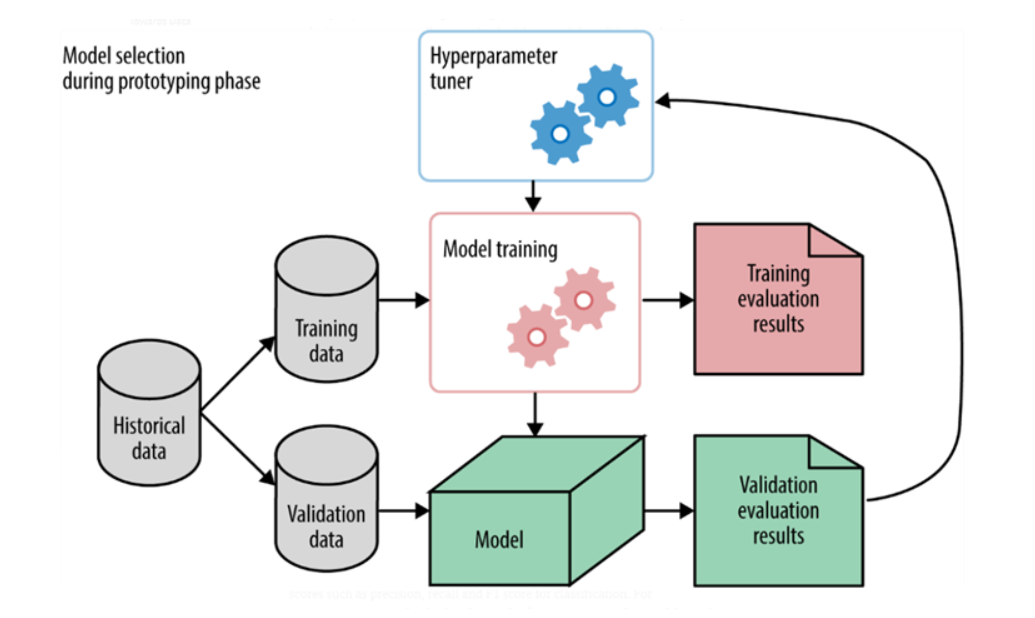

**<span style="color:#0918D5 ;">As can be seen in the above figure, the hyperparameter tuner is external to the model and the tuning is done before model training. The result of the tuning process is the optimal values of hyperparameters which is then fed to the model training stage. Let me now introduce Optuna, an optimization library in Python that can be employed for hyperparameter optimization.</span>**

## **<span style="color:#0918D5 ;">Optuna</span>**

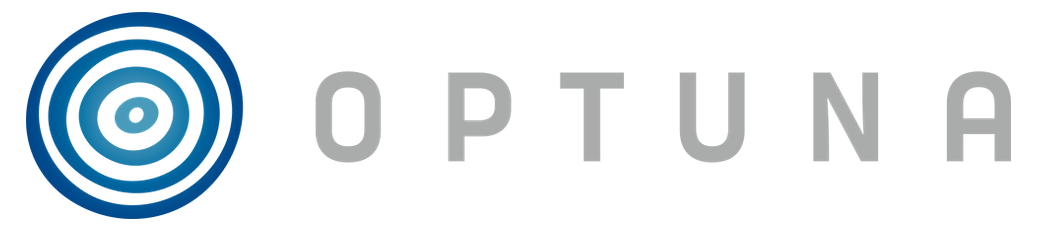

**<span style="color:#0918D5 ;">Optuna is a software framework for automating the optimization process of these hyperparameters. It automatically finds optimal hyperparameter values by making use of different samplers such as grid search, random, bayesian, and evolutionary algorithms. Let me first briefly describe the different samplers available in optuna.</span>**

- Grid Search: The search space of each hyper-parameter is discretized. The optimizer launches learning for each of the hyper-parameter configurations and selects the best at the end.
- Random: Randomly samples the search space and continues until the stopping criteria are met.
- Bayesian: Probabilistic model-based approach for finding the optimal hyperparameters
- Evolutionary algorithms: •Meta-heuristic approaches that employ the value of the fitness function to find the optimal hyperparameters.

## **<span style="color:#0918D5 ;">Why Optuna?</span>**
The following features of optuna encouraged us to use it for hyperparameter tuning for the problems we were trying to solve!
- Eager dynamic search spaces
- Efficient sampling and pruning algorithms
- Easy integration
- Good visualizations
- Distributed optimization

In [ ]:
# Function to plot Confusion Matrix (to be used later).
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.copper_r):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    # Hide grid lines
    plt.grid(False)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [ ]:
"""Creating Features and Label"""
features = train.drop('Transported', axis =1)
label = train.Transported

## **<span style="color:#0918D5 ;">Hyper-Parameter Tuning for KNN</span>**

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
def objective(trial):
    final_scores = []
    for fold, (train_indicies, valid_indicies) in enumerate(skf.split(features,label )): # creating Stratify-5-Folds
        xtrain, ytrain = features.iloc[train_indicies], label.iloc[train_indicies]         # assigning xtrain, ytrain
        xvalid, yvalid = features.iloc[valid_indicies], label.iloc[valid_indicies]         # assigning xvalid, yvalid


        xtrain = xtrain[useful_cols]
        xvalid = xvalid[useful_cols]
        
        
        scaler = preprocessing.PowerTransformer()
        xtrain[col_num] = scaler.fit_transform(xtrain[col_num])
        xvalid[col_num] = scaler.transform(xvalid[col_num])
        
        # Modelling 
        params =   {'n_neighbors' : trial.suggest_int('n_neighbors', 2, 100)
        ,'algorithm' : trial.suggest_categorical('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute'])
        ,'weights' : trial.suggest_categorical('weights', ['uniform','distance'])
        ,'metric' : trial.suggest_categorical('metric', ['minkowski','euclidean'])
        , 'leaf_size' : trial.suggest_int('leaf_size', 10, 300)
        }
        model = KNeighborsClassifier(**params)                          # Initialization of KNeighborsClassifier Class
        model.fit(xtrain,ytrain)                                        # Training the Model on training set

        # Predictions and Evaluation
        preds_valid = model.predict(xvalid)                              # Validating the model on Validation data.
        acc_score = metrics.accuracy_score(yvalid, preds_valid)          # Evaluating the model using accuracy
        final_scores.append(acc_score)
        print(fold, acc_score)
    print(f"Mean Score{np.mean(final_scores)}")
    return np.mean(final_scores)
study_knn = optuna.create_study(direction='maximize')                       # direction = "maximize", optuna will try to maximize the accuracy
study_knn.optimize(objective, n_trials=100)                                 # Running our objective function for 100 trials.

In [ ]:
trial_knn = study_knn.best_trial
print('roc_auc_score: {}'.format(trial_knn.value))
print("Best hyperparameters: {}".format(trial_knn.params))

In [ ]:
optuna.visualization.plot_optimization_history(study_knn)

In [ ]:
optuna.visualization.plot_slice(study_knn)

## **<span style="color:#0918D5 ;">Hypertuning Random Forest using Optuna</span>**

In [ ]:
def objective(trial):
    final_scores = []
    for fold, (train_indicies, valid_indicies) in enumerate(skf.split(features,label )): # creating Stratify-5-Folds
        xtrain, ytrain = features.iloc[train_indicies], label.iloc[train_indicies]         # assigning xtrain, ytrain
        xvalid, yvalid = features.iloc[valid_indicies], label.iloc[valid_indicies]         # assigning xvalid, yvalid

        xtrain = xtrain[useful_cols]
        xvalid = xvalid[useful_cols]        
        
        scaler = preprocessing.PowerTransformer()
        xtrain[col_num] = scaler.fit_transform(xtrain[col_num])
        xvalid[col_num] = scaler.transform(xvalid[col_num])
        
        # Modelling 
        params =   {'n_estimators' : trial.suggest_int('n_estimators', 50, 800)
        ,'max_depth' : trial.suggest_int('max_depth', 7, 150)
        , 'criterion' : trial.suggest_categorical('criterion',['gini', 'entropy'])
        , 'max_features' : trial.suggest_categorical('max_features',['auto', 'sqrt', 'log2'])
        , 'oob_score' : trial.suggest_categorical('oob_score',[True, False])
        }
        model = RandomForestClassifier(**params)                        # Initialization of RandomForestClassifier Class
        model.fit(xtrain,ytrain)                                        # Training the Model on training set

        # Predictions and Evaluation
        preds_valid = model.predict(xvalid)                             # Validating the model on Validation data.
        accuracy_scr = metrics.accuracy_score(yvalid, preds_valid)      # Evaluating the model using roc_aucc_curve

        final_scores.append(accuracy_scr)

        print(fold, accuracy_scr)
    print(f"Mean Score{np.mean(accuracy_scr)}")
    return np.mean(final_scores)
study_rf = optuna.create_study(direction='maximize')                    # direction = "maximize", optuna will try to maximize the roc_auc_score
study_rf.optimize(objective, n_trials=100)                                # Running our objective function for 100 trials.

In [ ]:
trial_rf = study_rf.best_trial
print(f'roc_auc_score: {trial_rf.value}')
print(f"Best hyperparameters: {trial_rf.params}")

In [ ]:
optuna.visualization.plot_optimization_history(study_rf)

In [ ]:
optuna.visualization.plot_slice(study_rf)

## **<span style="color:#0918D5 ;">Hypertune ExtraTreeClassifier using Optuna</span>**

In [ ]:
def objective(trial):
    final_scores = []
    for fold, (train_indicies, valid_indicies) in enumerate(skf.split(features,label )): # creating Stratify-5-Folds
        xtrain, ytrain = features.iloc[train_indicies], label.iloc[train_indicies]         # assigning xtrain, ytrain
        xvalid, yvalid = features.iloc[valid_indicies], label.iloc[valid_indicies]         # assigning xvalid, yvalid

        xtrain = xtrain[useful_cols]
        xvalid = xvalid[useful_cols]        
        
        scaler = preprocessing.PowerTransformer()
        xtrain[col_num] = scaler.fit_transform(xtrain[col_num])
        xvalid[col_num] = scaler.transform(xvalid[col_num])

        # Modelling 
        params =   {'n_estimators' : trial.suggest_int('n_estimators', 10, 1000)
        ,'max_depth' : trial.suggest_int('max_depth', 3, 300)
        , 'criterion' : trial.suggest_categorical('criterion',['gini', 'entropy'])
        , 'max_features' : trial.suggest_categorical('max_features',['auto', 'sqrt', 'log2'])
        , 'oob_score' : trial.suggest_categorical('oob_score',[True, False])
        }
        model = ExtraTreesClassifier(**params, bootstrap = True)                      # Initialization of ExtraTreesClassifier Class
        model.fit(xtrain,ytrain)                                                      # Training the Model on training set

        # Predictions and Evaluation
        preds_valid = model.predict(xvalid)                                           # Validating the model on Validation data.
        accuracy_scr = metrics.accuracy_score(yvalid, preds_valid)                    # Evaluating the model using roc_aucc_curve

        final_scores.append(accuracy_scr)
        print(fold, accuracy_scr)
    print(f"Mean Score{np.mean(accuracy_scr)}")
    return np.mean(final_scores)
study_etc = optuna.create_study(direction='maximize')                             # direction = "maximize", optuna will try to maximize the roc_auc_score
study_etc.optimize(objective, n_trials=100)                                        # Running our objective function for 15 trials.

In [ ]:
trial_etc = study_etc.best_trial
print(f'roc_auc_score: {trial_etc.value}')
print(f"Best hyperparameters: {trial_etc.params}")

In [ ]:
optuna.visualization.plot_optimization_history(study_etc)

In [ ]:
optuna.visualization.plot_slice(study_etc)

## **<span style="color:#0918D5 ;">Hypertune XGBclassifier using Optuna</span>**

In [ ]:
def objective(trial):
    final_scores=[]
    for fold, (train_indicies, valid_indicies) in enumerate(skf.split(features,label )): # creating Stratify-5-Folds
        xtrain, ytrain = features.iloc[train_indicies], label.iloc[train_indicies]         # assigning xtrain, ytrain
        xvalid, yvalid = features.iloc[valid_indicies], label.iloc[valid_indicies]         # assigning xvalid, yvalid

        xtrain = xtrain[useful_cols]
        xvalid = xvalid[useful_cols]        
        
        scaler = preprocessing.PowerTransformer()
        xtrain[col_num] = scaler.fit_transform(xtrain[col_num])
        xvalid[col_num] = scaler.transform(xvalid[col_num])

        # Modelling 
        params =   {
            'max_depth': trial.suggest_int('max_depth', 50, 1000), 
            'n_estimators': trial.suggest_int('n_estimators', 20, 800), 
            'eta': trial.suggest_float('eta', 0.007, 0.013), 
            'subsample': trial.suggest_discrete_uniform('subsample', 0.2, 0.9, 0.1),
            'colsample_bytree': trial.suggest_discrete_uniform('colsample_bytree', 0.2, 0.9, 0.1),
            'colsample_bylevel': trial.suggest_discrete_uniform('colsample_bylevel', 0.2, 0.9, 0.1),
            'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 1e4), 
            'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 1e4),
            'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 1e4), 
            'gamma': trial.suggest_loguniform('gamma', 1e-3, 1e4),
            'eval_metric' : 'auc',
            'objective' : 'binary:logistic',
            }
        model = XGBClassifier(**params)                      # Initialization of XGBClassifier Class
        model.fit(xtrain,ytrain)                                                      # Training the Model on training set

        # Predictions and Evaluation
        preds_valid = model.predict(xvalid)                                     # Validating the model on Validation data.
        accuracy_scr = metrics.accuracy_score(yvalid, preds_valid)                    # Evaluating the model using roc_aucc_curve

        final_scores.append(accuracy_scr)
        print(fold, accuracy_scr)
    print(f"Mean Score{np.mean(accuracy_scr)}")
    return np.mean(final_scores)
study_xgb = optuna.create_study(direction='maximize')                             # direction = "maximize", optuna will try to maximize the roc_auc_score
study_xgb.optimize(objective, n_trials=100)                                        # Running our objective function for 100 trials.

In [ ]:
trial_xgb = study_xgb.best_trial
print(f'roc_auc_score: {trial_xgb.value}')
print(f"Best hyperparameters: {trial_xgb.params}")

In [ ]:
optuna.visualization.plot_optimization_history(study_xgb)

In [ ]:
optuna.visualization.plot_slice(study_xgb)

## **<span style="color:#0918D5 ;">Hypertune Multi-Layer Perceptron</span>**

In [ ]:
def objective(trial):
    final_scores = []
    for fold, (train_indicies, valid_indicies) in enumerate(skf.split(features,label )): # creating Stratify-5-Folds
        xtrain, ytrain = features.iloc[train_indicies], label.iloc[train_indicies]         # assigning xtrain, ytrain
        xvalid, yvalid = features.iloc[valid_indicies], label.iloc[valid_indicies]         # assigning xvalid, yvalid


        xtrain = xtrain[useful_cols]
        xvalid = xvalid[useful_cols]        
        
        scaler = preprocessing.PowerTransformer()
        xtrain[col_num] = scaler.fit_transform(xtrain[col_num])
        xvalid[col_num] = scaler.transform(xvalid[col_num])        

        # Modelling 
        params = {
            'alpha': trial.suggest_loguniform('alpha',1e-4,1), 
            'hidden_layer_sizes': trial.suggest_int('hidden_layer_sizes',5,100),
            'max_iter': trial.suggest_int('max_iter',30,200)}
        model = MLPClassifier(**params)                                               # Initialization of MLPClassifier Class
        model.fit(xtrain,ytrain)                                                      # Training the Model on training set

        # Predictions and Evaluation
        preds_valid = model.predict(xvalid)                                           # Validating the model on Validation data.
        accuracy_scr = metrics.accuracy_score(yvalid, preds_valid)                    # Evaluating the model using roc_aucc_curve
        final_scores.append(accuracy_scr)
        print(fold, accuracy_scr)
        
    print(f"Mean Score{np.mean(accuracy_scr)}")
    return np.mean(final_scores)
study_mlp = optuna.create_study(direction='maximize')                             # direction = "maximize", optuna will try to maximize the roc_auc_score
study_mlp.optimize(objective, n_trials=100)                                        # Running our objective function for 100 trials.

In [ ]:
trial_mlp = study_mlp.best_trial
print(f'roc_auc_score: {trial_mlp.value}')
print(f"Best hyperparameters: {trial_mlp.params}")

In [ ]:
optuna.visualization.plot_optimization_history(study_mlp)

In [ ]:
optuna.visualization.plot_slice(study_mlp)

## **<span style="color:#0918D5 ;">Hypertune SVC using Optuna</span>**

In [ ]:
def objective(trial):
    final_scores = []
    for fold, (train_indicies, valid_indicies) in enumerate(skf.split(features,label )): # creating Stratify-5-Folds
        xtrain, ytrain = features.iloc[train_indicies], label.iloc[train_indicies]         # assigning xtrain, ytrain
        xvalid, yvalid = features.iloc[valid_indicies], label.iloc[valid_indicies]         # assigning xvalid, yvalid


        xtrain = xtrain[useful_cols]
        xvalid = xvalid[useful_cols]        
        
        scaler = preprocessing.PowerTransformer()
        xtrain[col_num] = scaler.fit_transform(xtrain[col_num])
        xvalid[col_num] = scaler.transform(xvalid[col_num])
        
        # Modelling 
        params =   {'C' : trial.suggest_float('C', 0.00001, 10.0)
        ,'max_iter' : trial.suggest_int('max_iter', 50, 1000)
        , 'kernel' : trial.suggest_categorical('kernel',['linear', 'poly', 'rbf', 'sigmoid'])
        , 'gamma' : trial.suggest_categorical('gamma',['scale', 'auto'])
        , 'class_weight' : trial.suggest_categorical('class_weight',['balanced'])
#         , 'probability' : trial.suggest_categorical('probability',[True])
        }
        model = SVC(**params)                                                         # Initialization of SVC Class
        model.fit(xtrain,ytrain)                                                      # Training the Model on training set

        # Predictions and Evaluation
        preds_valid = model.predict(xvalid)                                           # Validating the model on Validation data.
        accuracy_scr = metrics.accuracy_score(yvalid, preds_valid)                    # Evaluating the model using roc_aucc_curve

        final_scores.append(accuracy_scr)
        print(fold, accuracy_scr)
    print(f"Mean Score{np.mean(accuracy_scr)}")
    return np.mean(final_scores)
study_svc = optuna.create_study(direction='maximize')                             # direction = "maximize", optuna will try to maximize the roc_auc_score
study_svc.optimize(objective, n_trials=100)                                       # Running our objective function for 100 trials.

In [ ]:
trial_svc = study_svc.best_trial
print(f'roc_auc_score: {trial_svc.value}')
print(f"Best hyperparameters: {trial_svc.params}")

In [ ]:
optuna.visualization.plot_optimization_history(study_svc)

In [ ]:
optuna.visualization.plot_slice(study_svc)

## **<span style="color:#0918D5 ;">Hypertune Logistic Regression using Optuna</span>**

In [ ]:
def objective(trial):
    final_scores =[]
    for fold, (train_indicies, valid_indicies) in enumerate(skf.split(features,label )): # creating Stratify-5-Folds
        xtrain, ytrain = features.iloc[train_indicies], label.iloc[train_indicies]         # assigning xtrain, ytrain
        xvalid, yvalid = features.iloc[valid_indicies], label.iloc[valid_indicies]         # assigning xvalid, yvalid

        xtrain = xtrain[useful_cols]
        xvalid = xvalid[useful_cols]        
        
        scaler = preprocessing.PowerTransformer()
        xtrain[col_num] = scaler.fit_transform(xtrain[col_num])
        xvalid[col_num] = scaler.transform(xvalid[col_num])

        # Modelling 
        params =   {'C' : trial.suggest_float('C', 0.0001, 5.0)
        ,'max_iter' : trial.suggest_int('max_iter', 50, 1000)
        , 'penalty' : trial.suggest_categorical('penalty',['l1', 'l2'])
        , 'solver' : trial.suggest_categorical('solver',['liblinear'])
        }
        model = LogisticRegression(**params)                                          # Initialization of LogisticRegression Class
        model.fit(xtrain,ytrain)                                                      # Training the Model on training set

        # Predictions and Evaluation
        preds_valid = model.predict(xvalid)                                    # Validating the model on Validation data.
        accuracy_scr = metrics.accuracy_score(yvalid, preds_valid)                    # Evaluating the model using roc_aucc_curve

        final_scores.append(accuracy_scr)
        print(fold, accuracy_scr)
    print(f"Mean Score{np.mean(accuracy_scr)}")
    return np.mean(final_scores)
study_lr = optuna.create_study(direction='maximize')                             # direction = "maximize", optuna will try to maximize the roc_auc_score
study_lr.optimize(objective, n_trials=100)                                        # Running our objective function for 100 trials.

In [ ]:
trial_lr = study_lr.best_trial
print(f'roc_auc_score: {trial_lr.value}')
print(f"Best hyperparameters: {trial_lr.params}")

In [ ]:
optuna.visualization.plot_optimization_history(study_lr)

In [ ]:
optuna.visualization.plot_slice(study_lr)

## **<span style="color:#0918D5 ;">Hypertune LightGBM using Optuna</span>**

In [ ]:
def objective(trial):
    final_scores =[]
    for fold, (train_indicies, valid_indicies) in enumerate(skf.split(features,label )): # creating Stratify-5-Folds
        xtrain, ytrain = features.iloc[train_indicies], label.iloc[train_indicies]         # assigning xtrain, ytrain
        xvalid, yvalid = features.iloc[valid_indicies], label.iloc[valid_indicies]         # assigning xvalid, yvalid

        xtrain = xtrain[useful_cols]
        xvalid = xvalid[useful_cols]        
        
        scaler = preprocessing.PowerTransformer()
        xtrain[col_num] = scaler.fit_transform(xtrain[col_num])
        xvalid[col_num] = scaler.transform(xvalid[col_num])

        # Modelling 
        params = {"verbosity":trial.suggest_int("verbosity",-1, -1),
        # "device_type": trial.suggest_categorical("device_type", ['gpu']),
        "min_child_samples": trial.suggest_int("min_child_samples", 50, 700),
        "n_estimators": trial.suggest_int("n_estimators", 50, 8000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.15),
        "num_leaves": trial.suggest_int("num_leaves", 10, 1000, step=20),
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        "max_bin": trial.suggest_int("max_bin", 10, 1000),
        "cat_l2": trial.suggest_int("cat_l2", 10, 100),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 10, 7000),
        "lambda_l1": trial.suggest_int("lambda_l1", 3, 200),
        "lambda_l2": trial.suggest_int("lambda_l2", 3, 200),
        "random_state": trial.suggest_categorical("random_state",[7,10,42,42]),
        "boosting_type": trial.suggest_categorical("boosting_type",["gbdt"]),
        "objective": trial.suggest_categorical("objective",["binary"]),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 2.0, 5.0),
#         "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1),
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.01, 1.0, step=0.1
        ),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float(
            "feature_fraction", 0.01, 1.0, step=0.1
        ),}
        
        model =LGBMClassifier(**params)
        model.fit(xtrain,ytrain,verbose=False)

        preds_valid = model.predict(xvalid)                                   # Validating the model on Validation data.
        accuracy_scr = metrics.accuracy_score(yvalid, preds_valid)                    # Evaluating the model using roc_aucc_curve

        final_scores.append(accuracy_scr)
        print(fold, accuracy_scr)
    print(f"Mean Score{np.mean(accuracy_scr)}")
    return np.mean(final_scores)
study_lgbm = optuna.create_study(direction='maximize')                             # direction = "maximize", optuna will try to maximize the roc_auc_score
study_lgbm.optimize(objective, n_trials=100)                                        # Running our objective function for 100 trials.

In [ ]:
trial_lgbm = study_lgbm.best_trial
print(f'roc_auc_score: {trial_lgbm.value}')
print(f"Best hyperparameters: {trial_lgbm.params}")

In [ ]:
optuna.visualization.plot_optimization_history(study_lgbm)

In [ ]:
optuna.visualization.plot_slice(study_lgbm)

## **<span style="color:#0918D5 ;">Hypertune CatBoost using Optuna</span>**

In [ ]:

def objective(trial):
    final_scores =[]
    for fold, (train_indicies, valid_indicies) in enumerate(skf.split(features,label )): # creating Stratify-5-Folds
        xtrain, ytrain = features.iloc[train_indicies], label.iloc[train_indicies]         # assigning xtrain, ytrain
        xvalid, yvalid = features.iloc[valid_indicies], label.iloc[valid_indicies]         # assigning xvalid, yvalid

        xtrain = xtrain[useful_cols]
        xvalid = xvalid[useful_cols]        
        
        scaler = preprocessing.PowerTransformer()
        xtrain[col_num] = scaler.fit_transform(xtrain[col_num])
        xvalid[col_num] = scaler.transform(xvalid[col_num])

        # Modelling 
        params = {'iterations':trial.suggest_int("iterations", 4000, 8000),
              'od_wait':trial.suggest_int('od_wait', 30, 80),
             'loss_function':'Logloss',
#               'task_type':"GPU",
              'eval_metric': trial.suggest_categorical("eval_metric", ['Logloss','Accuracy']), 
              'leaf_estimation_method':'Newton',
              "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["MVS"]),
              'learning_rate' : trial.suggest_uniform('learning_rate',0.05,0.1),
              'reg_lambda': trial.suggest_uniform('reg_lambda',7,10),
              'subsample': trial.suggest_uniform('subsample',0.3,0.7),
              'random_strength': trial.suggest_uniform('random_strength',30,45),
              'depth': trial.suggest_int('depth',7,12),
              'min_data_in_leaf': trial.suggest_int('min_data_in_leaf',10,20),
              'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations',1,5),
               }
        if params["bootstrap_type"] == "Bernoulli":
            params["subsample"] = trial.suggest_float("subsample", 0.1, 1)
            
        model = CatBoostClassifier(**params)  
        model.fit(xtrain,ytrain,eval_set=[(xvalid,yvalid)],early_stopping_rounds=100,verbose=False)


        preds_valid = model.predict(xvalid)                                   # Validating the model on Validation data.
        accuracy_scr = metrics.accuracy_score(yvalid, preds_valid)                    # Evaluating the model using roc_aucc_curve

        final_scores.append(accuracy_scr)
        print(fold, accuracy_scr)
    print(f"Mean Score{np.mean(accuracy_scr)}")
    return np.mean(final_scores)
study_catb = optuna.create_study(direction='maximize')                             # direction = "maximize", optuna will try to maximize the roc_auc_score
study_catb.optimize(objective, n_trials=100)                                        # Running our objective function for 100 trials.

In [ ]:
trial_catb = study_catb.best_trial
print(f'roc_auc_score: {trial_catb.value}')
print(f"Best hyperparameters: {trial_catb.params}")

In [ ]:
optuna.visualization.plot_optimization_history(study_catb)

In [ ]:
optuna.visualization.plot_slice(study_catb)

## **<span style="color:#0918D5 ;">Just for fun let's predict using 5 models</span>**

In [ ]:
catboost_params = {'iterations': 7498, 'od_wait': 38, 'eval_metric': 'Accuracy', 'bootstrap_type': 'MVS',
 'learning_rate': 0.09991417057853538, 'reg_lambda': 8.662405499729667, 'subsample': 0.48859245712938665,
 'random_strength': 42.66162744342859, 'depth': 8, 'min_data_in_leaf': 11, 'leaf_estimation_iterations': 2}

rf_params = {'n_estimators': 509, 'max_depth': 11, 'criterion': 'gini', 'max_features': 'log2', 'oob_score': False}

etc_params = {'n_estimators': 862, 'max_depth': 19, 'criterion': 'entropy', 'max_features': 'log2', 'oob_score': False}

xgb_params = {'max_depth': 307, 'n_estimators': 790, 'eta': 0.007721783355171602, 'subsample': 0.5, 'colsample_bytree': 0.8,
              'colsample_bylevel': 0.4,              'min_child_weight': 6.21494825802506, 
              'reg_lambda': 0.13517419299596198, 'reg_alpha': 0.001285106869161023, 'gamma': 6.325255313888779}

lgb_params = {'verbosity': -1, 'min_child_samples': 564, 'n_estimators': 5894, 'learning_rate': 0.10642637493230094, 
              'num_leaves': 110, 'max_depth': 7, 'max_bin': 386, 'cat_l2': 10, 'min_data_in_leaf': 213, 'lambda_l1': 17,
              'lambda_l2': 22, 'random_state': 42, 'boosting_type': 'gbdt', 'objective': 'binary', 'min_gain_to_split': 2.685396872235298, 
              'bagging_fraction': 0.91, 'bagging_freq': 1, 'feature_fraction': 0.91}


In [ ]:
model_catboost = CatBoostClassifier(**catboost_params, verbose = False) 
model_rf = RandomForestClassifier(**rf_params)
model_etc = ExtraTreesClassifier(**etc_params)
model_xgb = XGBClassifier(**xgb_params)
model_lgb = LGBMClassifier(**lgb_params, verbose = False)

In [ ]:
final_test_predictions_vclf = [] #to store final test predictions
final_valid_predictions_vclf = [] # to store final validation predictions
scores = [] #to store the scores


for fold, (train_indicies, valid_indicies) in enumerate(skf.split(features,label )):   # creating Stratify-5-Folds
    xtrain, ytrain = features.iloc[train_indicies], label.iloc[train_indicies]         # creating xtrain, ytrain
    xvalid, yvalid = features.iloc[valid_indicies], label.iloc[valid_indicies]         # creating xvalid and yvalid
    xtest= test.copy()


    xtrain = xtrain[useful_cols]
    xvalid = xvalid[useful_cols] 
    xtest = xtest[useful_cols]

    scaler = preprocessing.PowerTransformer()
    xtrain[col_num] = scaler.fit_transform(xtrain[col_num])
    xvalid[col_num] = scaler.transform(xvalid[col_num])    # Model building using parameters obtain from Optuna hyper-parameter tuning
    xtest[col_num] = scaler.transform(xtest[col_num]) 
    # params = trial_lr.params

    model_vclf = VotingClassifier(estimators=[ 
                                              ('CatBoost', model_catboost),       
                                               ('RF', model_rf),                  # RandomForest Classifier
                                               ('ETC', model_etc),                # ExtraTreesClassifier
                                              ('XGB', model_xgb),                 # XGBosst Classifier
                                              ('LGB', model_lgb),              
                                              #  ('SVC', model_svc),                                              
                                              ],                  
                                  voting='hard')                                      # Used Hard voting
    model_vclf.fit(xtrain, ytrain)                                                    # Training the model

    preds_valid = model_vclf.predict(xvalid)                             # Prediction on validation data
    test_preds = model_vclf.predict(xtest)                                # Prediction on test data
    final_test_predictions_vclf.append(test_preds)                                    # Appending test predictions to list
    final_valid_predictions_vclf.append(preds_valid)                                  # Appending validation predictions to list
    accuracy_scr = metrics.accuracy_score(yvalid, preds_valid)                  # Evaluating validation predictions using roc_auc_score
                    # Evaluating Test predictions using roc_auc_score
    print(f'Fold {fold} Accuracy_valid: ', accuracy_scr)                            # Printing fold and AUC_validation
                           # Printing fold and AUC_test
    scores.append(accuracy_scr)                                                # Appending validation score to list
    
    
print(np.mean(scores), np.std(scores))                                                # Printing Mean and Standard Deviation of Scores.

In [ ]:
sample_submission = pd.read_csv('../input/spaceship-titanic/sample_submission.csv')

sample_submission['Class_1']=final_test_predictions_vclf[0]
sample_submission['Class_2']=final_test_predictions_vclf[1]
sample_submission['Class_3']=final_test_predictions_vclf[2]
sample_submission['Class_4']=final_test_predictions_vclf[3]
sample_submission['Class_5']=final_test_predictions_vclf[4]
sample_submission['mean_of_all']=np.mean(np.column_stack(final_test_predictions_vclf), axis=1)

sample_submission.head(20)

In [ ]:
sample_submission['Transported'] = sample_submission['mean_of_all'].apply(lambda x: x>=0.5)
sample_submission[['PassengerId', 'Transported']].to_csv('submission_1.csv', index = False)
sample_submission.head(50)

## **<span style="color:#0918D5 ;">I smile on every Upvote :)</span>**